In [1]:
import pyross.tsi as pyrosstsi 
import numpy as np
import nlopt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

In [2]:
T = 15                                       # Longest  infectious duration
Td = 5                                       # Doubling time in linear growth regime
Tf = 150                                     # Duration of simulation

tsi  = np.array([0,   3,    5,   10,   T])   # Time since infection (days)
beta = np.array([0,   0.5,  1,   .5,   0])   # Mean infectiousness 

M = 2                                        # Number of age groups to model
Ni = 10**6*np.ones(M)                        # Number of people in each age group
Np = sum(Ni)                                 # Total population size

#how many 'stages' to resolve in time since infection?
Nk = 10

#define a time-dependent contact matrix.
def contactMatrix_0(t):
    return np.array([[4, 1],[1, 2]]);


subclasses = ['Recovered', 'Hospitalized', 'Mortality']  
pR = 0.99*np.ones(M);  #probability of eventually recovering for each age class
pH = 0.05*np.ones(M);  #probability of needing hospitalization for each age class
pD = 1-pR;             #probability of death for each age class

#prepare for a linear interpolating function evaluated at times:
tsi_sc  =  np.array([0,   3.,    6.,    9.,   12,    T])   

phiR     = np.array([0,    0,    0.5,   3,     2,     0])  #rate of transferring to 'recovered' (arbitrary units)
phiH_in  = np.array([0,    0,    1,     1,     0,     0])  #rate that people enter hospital     (arbitrary units)
phiH_out = np.array([0,    0,    0,     1,     1,     0])  #rate that people enter hospital     (arbitrary units)
phiD     = np.array([0,    0,    0,     1,     1,    .5])  #times at which a person dies        (arbitrary units)

#combine hospital in/out to a single function for net change in hospitalized cases
phiH = np.add(-phiH_out/np.trapz(phiH_out,tsi_sc),phiH_in/np.trapz(phiH_in,tsi_sc))

#normalize all to one -- can then be rescaled by approprate pR, pH, pD, etc. at a later time
phiR, phiD  = phiR/np.trapz(phiR,tsi_sc),  phiD/np.trapz(phiD,tsi_sc)

#group them all together for later processing
phi_alpha, p_alpha = np.array([phiR, phiH, phiD]), np.array([pR, pH, pD])

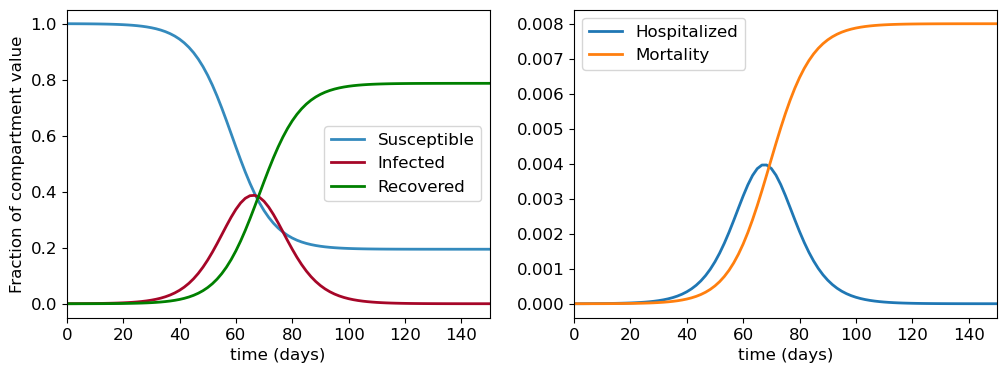

In [3]:
#Reference simulation:  No control              
    
parameters = {'M':M, 'Ni':Ni, 'Nc':len(subclasses), 'Nk':Nk, 'Tf':Tf, 'Tc':(T/2), 'T':T, 'Td':Td,
              'tsi':tsi,'beta':beta,'tsi_sc':tsi_sc, 'phi_alpha':phi_alpha, 'p_alpha':p_alpha, 
              'contactMatrix':contactMatrix_0}

#Set up and Solve
model = pyrosstsi.deterministic.Simulator(parameters)
IC    = model.get_IC()
data  = model.simulate(IC)

#unpack and rescale simulation output
t = data['t']; S_t = data['S_t']; I_t = data['I_t']; Ic_t = data['Ic_t'] 

plt.figure(figsize=(12, 4)); plt.subplot(121) 
plt.plot(t,np.sum(S_t,0), color="#348ABD", lw=2, label = 'Susceptible')           #all susceptible
plt.plot(t,np.sum(I_t,0), color="#A60628", lw=2, label = 'Infected')              #all Infected
plt.plot(t,np.sum(Ic_t[0,:,:],0), color='green', lw=2, label = 'Recovered')       #all Recovered
plt.xlabel('time (days)');       plt.xlim(0,Tf);  
plt.ylabel('Fraction of compartment value');   plt.legend()

plt.subplot(122) 
for i in (1 + np.arange(len(subclasses)-1)):
    plt.plot(t,np.sum(Ic_t[i,:,:],0), lw=2, label = subclasses[i])
plt.legend(); plt.xlabel('time (days)'); plt.xlabel('time (days)'); plt.xlim(0,Tf); 

## Set up a Function for Cost Evaluations

In [4]:
#####################################
##                                 ##
##   Generic cost fn Evaluation    ##
##                                 ##
#####################################

#Define the particular cost function

def evaluate_cost(t,u_t,S_t,I_t,Ic_t,cost_params):
    #unpack cost params
    Omega = cost_params
    
    #evaluate costs from infections/death
    nt = len(t)
    pos = 2
    cost_health = np.sum(Ic_t[pos,:,nt-1])
  
    #evaluate costs from implementing controls:
    cost_NPI = Omega*np.trapz(np.sum(((1-u_t)**2)*S_t,0),t)
    return (cost_health + cost_NPI)


#Set a function to compute outcomes and evaluate cost function

def get_cost(x, gradx, IC, cost_params, evaluate_cost,print_figs = False):
    
    
    #set up the time-dependent contact matrix based on control scheme
    nu = int((len(x) + 2)/(M + 1))
    t_con = np.append(np.append(0, x[:(nu - 2)]),Tf)
    u_con = np.reshape(x[(nu - 2):],(M,nu))
    def contactMatrix(t):
        u = np.zeros(M)
        if t == 0:
            return contactMatrix_0(t) #this is needed because rescalings are done inside pyrosstsi based on this
        else:
            for i in range(M):
                u[i] = np.interp(t,t_con,u_con[i,:])
            return np.outer(u,u)*contactMatrix_0(t)

    parameters['contactMatrix'] = contactMatrix
    
    #let's not messs around with poorly sorted lists
    for i in range(nu - 1):
        if t_con[i + 1] < t_con[i]:
            return float('inf')
    
    #set up and solve
    model = pyrosstsi.deterministic.Simulator(parameters)
    data  = model.simulate(IC)
    #unpack and rescale simulation output
    t = data['t']; S_t = data['S_t']; I_t = data['I_t']; Ic_t = data['Ic_t'] 
    
    #compute cost function
    nt = len(t)
    u_t = np.zeros((M,nt))
    for j in range(M):
        u_t[j,:] = np.interp(t,t_con,u_con[j,:])
        
    #Standard SIR plot
    if print_figs:
        plt.figure()    
        plt.plot(t,np.sum(S_t,0),'r', label = 'Susceptible')           #all susceptible
        plt.plot(t,np.sum(I_t,0),'b', label = 'Infected')              #all Infected
        plt.plot(t,np.sum(Ic_t[0,:,:],0),'g', label = subclasses[0])   #all recovered
        plt.legend()
        plt.xlabel('time (days)');       plt.xlim(0,Tf)
        plt.ylabel('number of people');  plt.ylim(0,1)
    
    return evaluate_cost(t,u_t,S_t,I_t,Ic_t,cost_params)



0.0067580162096733554


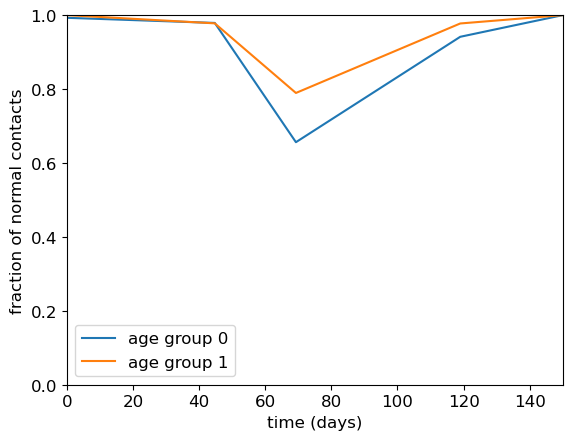

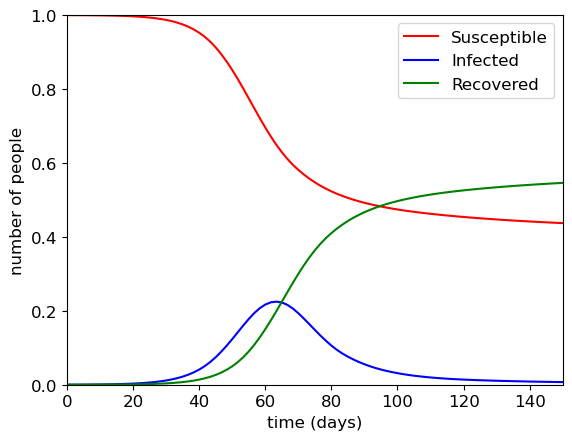

In [5]:
###################################
##                               ##
##       Optimize Controls       ##
##                               ##
###################################

###################################
##     Herd Immunity Example     ##
###################################


#Define input parameters to the cost function:
Omega = 10**-3   #input parameter to trial cost function.  Omega scales cost of lockdown to statistical value of life.
                 #low values represent cases where lockdowns are cheap (or disease is deadly)
                 #Generalizations should include age-structuring.
    
#bundle all input parameters together
cost_params = Omega
    
nu = 5           #how many interpolating points (including endpoints)

#set an initial guess (evenly spaced points, no intervention)
x0 = np.append(np.linspace(Tf/(nu - 1), Tf*(nu-2)/(nu-1),nu-2), np.ones(nu*M))
nx = len(x0)

#We use nlopt for optimization.
opt = nlopt.opt(nlopt.LN_COBYLA, nx)
opt.set_lower_bounds(np.zeros(nx))
opt.set_upper_bounds(np.append(Tf*np.ones(nu - 2),np.ones(nx - (nu - 2))))
opt.set_min_objective(lambda x, gradx: get_cost(x, gradx, IC, cost_params,evaluate_cost))
opt.set_xtol_rel(1e-3)#-4
x_opt = opt.optimize(x0)
minf = opt.last_optimum_value()

#group results and plot
t_con = np.append(np.append(0, x_opt[:(nu - 2)]),Tf)
u_con = np.reshape(x_opt[(nu - 2):],(M,nu))

plt.figure()
for i in range(M):
    lbl = ['age group ', str(i)]
    lbl = ''.join(lbl)
    plt.plot(t_con,u_con[i,:], label = lbl)
plt.legend()
plt.xlabel('time (days)');       plt.xlim(0,Tf)
plt.ylabel('fraction of normal contacts');  plt.ylim(0,1)

print(get_cost(x_opt, [], IC, cost_params,evaluate_cost,True))

0.0015772069801838432


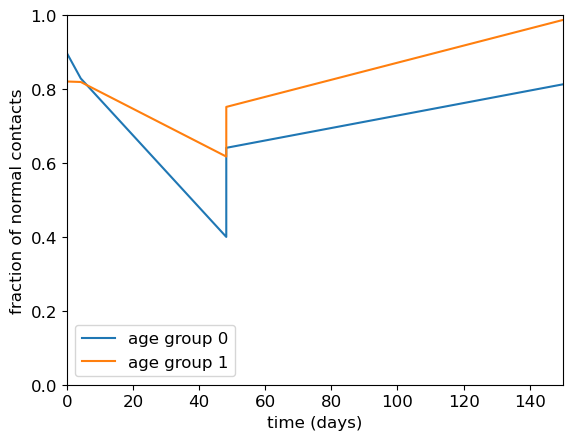

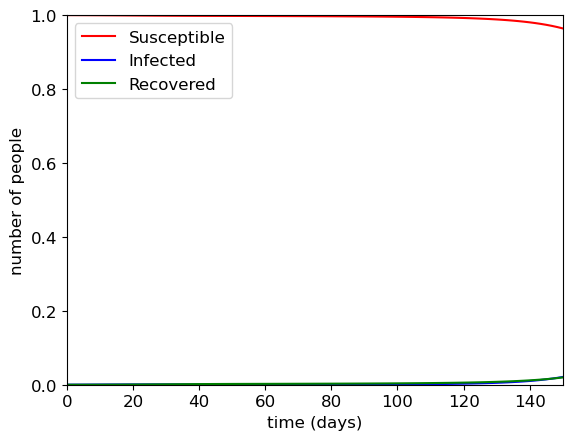

In [6]:
###################################
##                               ##
##       Optimize Controls       ##
##                               ##
###################################

###################################
##        Lockdown Example       ##
###################################


#Define input parameters to the cost function:
Omega = 10**-3*2/T   #input parameter to trial cost function.  Omega scales cost of lockdown to statistical value of life.
                 #low values represent cases where lockdowns are cheap (or disease is deadly)
                 #Generalizations should include age-structuring.
    
#bundle all input parameters together
cost_params = Omega
    
nu = 5           #how many interpolating points (including endpoints)

#set an initial guess (evenly spaced points, no intervention)
x0 = np.append(np.linspace(Tf/(nu - 1), Tf*(nu-2)/(nu-1),nu-2), np.ones(nu*M))
nx = len(x0)

#We use nlopt for optimization.
opt = nlopt.opt(nlopt.LN_COBYLA, nx)
opt.set_lower_bounds(np.zeros(nx))
opt.set_upper_bounds(np.append(Tf*np.ones(nu - 2),np.ones(nx - (nu - 2))))
opt.set_min_objective(lambda x, gradx: get_cost(x, gradx, IC, cost_params,evaluate_cost))
opt.set_xtol_rel(1e-3)#-4
x_opt = opt.optimize(x0)
minf = opt.last_optimum_value()

#group results and plot
t_con = np.append(np.append(0, x_opt[:(nu - 2)]),Tf)
u_con = np.reshape(x_opt[(nu - 2):],(M,nu))

plt.figure()
for i in range(M):
    lbl = ['age group ', str(i)]
    lbl = ''.join(lbl)
    plt.plot(t_con,u_con[i,:], label = lbl)
plt.legend()
plt.xlabel('time (days)');       plt.xlim(0,Tf)
plt.ylabel('fraction of normal contacts');  plt.ylim(0,1)

print(get_cost(x_opt, [], IC, cost_params,evaluate_cost,True))

In [7]:
Omega*T

0.002